In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from EddyTracks import EddyTracks, DifferentiateEddies, geodist

In [2]:
fpaths = ['/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik1_Rb_0p8_Rmin_2dx/',
          '/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik58_Rb_0p8_Rmin_2dx/',
          '/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik89_Rb_0p8_Rmin_2dx/']
depths = ['Surface', '500m', '1500m']
tracks_full = {depth:[] for depth in depths}  # dictionary for tracks at each depth

for i,fpath in enumerate(fpaths):
    tracks = EddyTracks(fpath)
    print(depths[i]+':', len(tracks), 'eddies')
    tracks_full[depths[i]] = tracks

Surface: 738 eddies
500m: 216 eddies
1500m: 216 eddies


In [3]:
lifetime = 0                                   # lifetime filter (in hours)
cyclones = {depth:[] for depth in depths}      # cyclonic eddies at each depth
anticyclones = {depth:[] for depth in depths}  # anticyclonic eddies at each depth

for depth in depths:
    # separate eddies by rotation
    tracks = tracks_full[depth]
    cyclones[depth], anticyclones[depth] = DifferentiateEddies(tracks)

print('Num Eddies')
for depth in depths:
    print(f'{depth:9}a: {len(anticyclones[depth])}  c: {len(cyclones[depth])}')

Num Eddies
Surface  a: 313  c: 425
500m     a: 115  c: 101
1500m    a: 104  c: 112


In [4]:
eddyTypes = ['anticyclone', 'cyclone']             # eddy types
stats = {eddyType:[] for eddyType in eddyTypes}    # statistics for each eddy type
statTypes = ['Lifetime', 'Propagation', 'Rossby Number', 'Max Radius']   # statistics
units = ['days', 'km', '', 'km']       # statistics units

# loop through cyclones and anticyclones
for eddyType in eddyTypes:
    print(eddyType.upper())
    stats[eddyType] = {depth:[] for depth in depths}  # set up stat dictionary for each depth
    for depth in depths:
        stats[eddyType][depth] = {statType:[] for statType in statTypes}
        if eddyType == 'cyclone':
            tracks = cyclones[depth]
        else:
            tracks = anticyclones[depth]
            
        for i, track in enumerate(tracks):
            # calculate distance
            dist = geodist(track['x1'], track['y1'])
            stats[eddyType][depth]['Propagation'].append(dist)
            
            # calculate Rossby number magnitude
            rossby = np.median(track['vort1']/track['f'])
            stats[eddyType][depth]['Rossby Number'].append(rossby)
            
            # calculate median eddy radius
            radius = np.median(track['rmax1'])
            stats[eddyType][depth]['Max Radius'].append(radius)
            
            # calculate lifetime
            lftm = (track['step'][-1] - track['step'][0] + 1)/24
            stats[eddyType][depth]['Lifetime'].append(lftm)
        
        # print results
        print(depth)
        for i,statType in enumerate(statTypes):
            print(f'mean {statType:8}{np.mean(stats[eddyType][depth][statType]).round(decimals=3):>12} {units[i]}')
            print(f'min {statType:9}{np.min(stats[eddyType][depth][statType]).round(decimals=3):>12} {units[i]}')
            print(f'max {statType:9}{np.max(stats[eddyType][depth][statType]).round(decimals=3):>12} {units[i]}')
        print()

ANTICYCLONE
Surface
mean Lifetime       0.932 days
min Lifetime        0.042 days
max Lifetime       30.375 days
mean Propagation      34.893 km
min Propagation         0.0 km
max Propagation    1480.328 km
mean Rossby Number      -0.191 
min Rossby Number      -1.085 
max Rossby Number      -0.039 
mean Max Radius       8.345 km
min Max Radius       3.032 km
max Max Radius      26.699 km

500m
mean Lifetime       4.029 days
min Lifetime        0.042 days
max Lifetime         32.0 days
mean Propagation       57.15 km
min Propagation         0.0 km
max Propagation      693.41 km
mean Rossby Number       -0.08 
min Rossby Number      -0.269 
max Rossby Number      -0.017 
mean Max Radius       5.959 km
min Max Radius       3.279 km
max Max Radius      18.007 km

1500m
mean Lifetime       4.951 days
min Lifetime        0.042 days
max Lifetime         32.0 days
mean Propagation      66.585 km
min Propagation         0.0 km
max Propagation     534.813 km
mean Rossby Number      -0.074 
min 

In [5]:
from matplotlib.ticker import FormatStrFormatter

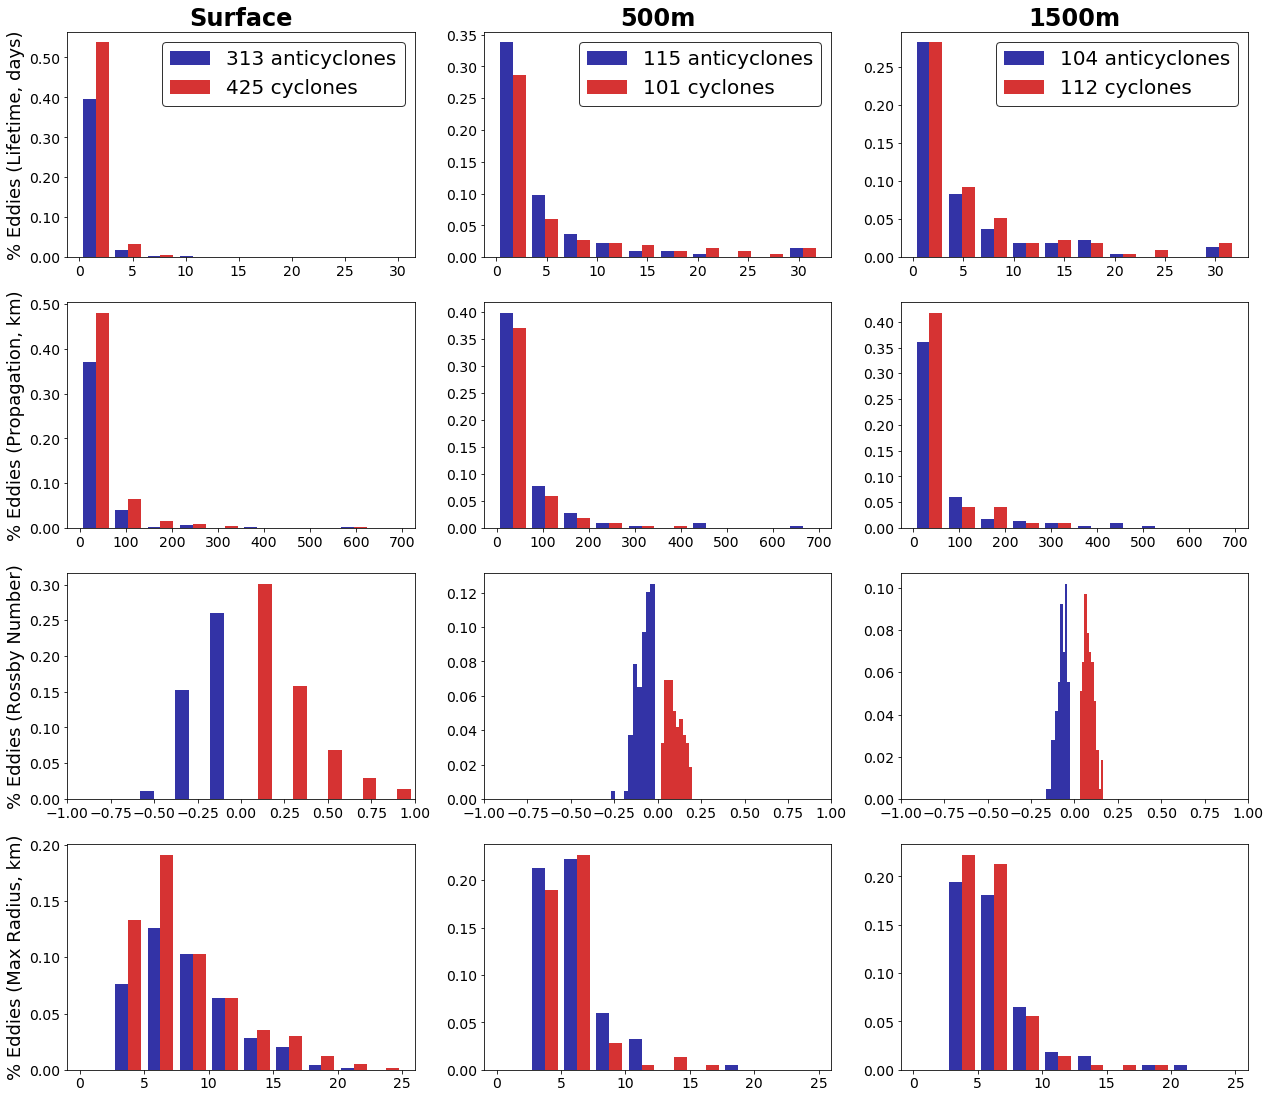

In [7]:
fig = plt.figure(figsize=(21.16,19.1))
plotStats = ['Lifetime', 'Propagation', 'Rossby Number', 'Max Radius']   # statistics to use

red = (1-0.2, 0,0,0.8)
blue = (0, 0, 1-0.4353,0.8)
colors = [blue, red]
j = 1
for i,plotStat in enumerate(plotStats):
    for depth in depths:
        nEddies = len(cyclones[depth]) + len(anticyclones[depth])              # total num eddies at this depth
        values = [stats[eddyType][depth][plotStat] for eddyType in eddyTypes]
        weights = [np.ones_like(value) / nEddies for value in values]          # normalize counts
        ax = fig.add_subplot(4,3,j)
        labels = [str(len(anticyclones[depth]))+' anticyclones', str(len(cyclones[depth]))+' cyclones']
        
        if plotStat == 'Propagation':
            ax.hist(values, bins=10, color=colors, label=labels, weights=weights, range=(0,700))
        elif plotStat == 'Rossby Number':
            if depth != 'Surface':
                for k,eddyType in enumerate(eddyTypes):
                    ax.hist(values[k],bins=10, color=colors[k], label=labels, weights=weights[k])
            else:
                ax.hist(values, bins=10, color=colors, label=labels, weights=weights, range=(-1,1))
            ax.set_xlim(-1,1)
        elif plotStat == 'Max Radius':
            ax.hist(values, bins=10, color=colors, label=labels, weights=weights, range=(0,25))
            plt.locator_params(axis='y', nbins=5)
        else:
            ax.hist(values, bins=10, color=colors, label=labels, weights=weights)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # format y-axis to two decimal points
        
        # Set the font size for axis tick labels
        for tick in ax.get_xticklabels():
            tick.set_fontsize(14)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(14)
        
        if j in [1,4,7,10,13]:
            if plotStat == 'Rossby Number':
                ax.set_ylabel('% Eddies ('+plotStat+')', fontsize=18)
            else:
                ax.set_ylabel('% Eddies ('+plotStat+', '+units[i]+')', fontsize=18)
        if j < 4:
            ax.set_title(depth, fontsize=24, fontweight='bold')
        if j<= 3:
            leg = plt.legend(fontsize=20)
            leg.get_frame().set_edgecolor('k')
        j += 1
plt.show()

fig_path = './figures/'
fname = 'stats.png'
fig.tight_layout()
fig.savefig(fig_path+fname, dpi=80)